<div style="text-align: right"> Christopher Gersch </div>

<left>FINM 35910 - Applied Algorithmic Trading</left> 

<h2><center> Homework 2 </center></h2>

Zakarya MEHDI

## 1. Formulate Investment Hypothesis and Goals

The  investment hypothesis is that certain pairs of stocks within the same sector exhibit a stable long-term equilibrium relationship. Deviations from this equilibrium are temporary and can be exploited for profit. By identifying cointegrated pairs and trading on the mean-reversion of their price spread, we aim to generate excess returns over the benchmark.

The main objective is to achieve returns that exceed those of the benchmark index, the S&P 500. We protect the initial capital by limiting losses through entry and exit points.


**Parameters:**

- Investment Universe: Stocks listed in the S&P 500 index with sufficient liquidity.
- Return Definition: Total return, including capital gains and transaction costs.
- Rebalancing Frequency: Monthly recalibration of cointegrated pairs, with daily monitoring of trading signals.
- Transaction Costs: Assumed at 0.1% per transaction, accounting for bid-ask spreads and commissions.
- Testing Period:
    - Calibration Period: January 1, 2021, to December 31, 2021.
    - Trading Period: January 1, 2022, to October 31, 2023.
- Initial Capital: $1,000,000 allocated equally across selected pairs.

**Testable Hypotheses**

Cointegration Hypothesis: Selected stock pairs within the same sector are cointegrated at a 95% confidence level (p-value < 0.05).

When the price spread between two cointegrated stocks deviates significantly from its mean (measured by the z-score), it will revert to the mean over time.

- Entry Criteria: Enter a position when the z-score of the spread exceeds ±2 standard deviations.
- Exit Criteria: Exit the position when the z-score reverts to within ±0.5 standard deviations.


**Liquidity Constraints**

Only stocks with an average daily trading volume exceeding 1 million shares are included to ensure sufficient liquidity and minimize market impact.

**Market Impact**

The strategy assumes that trades are executed at market prices without significantly affecting the stock prices due to the high liquidity of the chosen stocks.


## 2. Portfolio Construction and Rebalancing

Historical price and volume data for S&P 500 constituents were collected from January 1, 2019, to October 31, 2023, using the yfinance library.
Stocks with insufficient data or significant missing values were excluded.
Stocks with an average daily volume below 1 million shares were filtered out.

Pairs with a p-value less than 0.05 were considered cointegrated. The top 10 pairs with the strongest cointegration (lowest p-values) were selected for trading each month.

We assume a flat rate of 0.1% per transaction to simulate bid-ask spreads and commissions.

The strategy recalibrates monthly, updating the set of cointegrated pairs and hedge ratios. The initial capital is allocated equally across the selected pairs.

The entry and exit signals were defined as explained in section 1.

Positions are adjusted according to the signals, accounting for transaction costs.
Cointegrated pairs and hedge ratios are recalculated at the end of each month.
This frequency balances the need to adapt to changing market conditions while minimizing transaction costs from excessive rebalancing.

We monitor the spreads and trading signals on a daily basis to identify entry and exit opportunities.

In [92]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
import datetime as dt
import requests
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies' 
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml') 

    table = soup.find('table', {'id': 'constituents'})

    tickers = []
    sectors = {}
    for row in table.tbody.find_all('tr'):
        cols = row.find_all('td')
        if cols:
            ticker = cols[0].text.strip()
            ticker = ticker.replace('.', '-').replace('/', '-')
            sector = cols[3].text.strip()
            tickers.append(ticker)
            sectors[ticker] = sector
    return tickers, sectors

tickers, sector_map = get_sp500_tickers()
print(f"Number of tickers retrieved: {len(tickers)}")

Number of tickers retrieved: 503


In [94]:
tickers = [ticker.replace('.', '-') for ticker in tickers]

start_date = '2019-01-01'  
end_date = '2023-10-31'    

price_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
price_data = price_data.dropna(axis=1, how='any')

tickers = price_data.columns.tolist()
sector_map = {ticker: sector_map.get(ticker, 'Unknown') for ticker in tickers}

volume_data = yf.download(tickers, start=start_date, end=end_date, progress=False)['Volume']

average_volume = volume_data.mean()
liquid_tickers = average_volume[average_volume > 1e6].index.tolist()

price_data = price_data[liquid_tickers]
tickers = liquid_tickers
sector_map = {ticker: sector_map[ticker] for ticker in tickers}

print(f"Number of liquid tickers: {len(tickers)}")

[*********************100%%**********************]  503 of 503 completed


4 Failed downloads:
['AMTM', 'SW', 'SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 1546318800, endDate = 1698724800")



Number of liquid tickers: 384


In [95]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    keys = data.columns
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            stock1 = data[keys[i]]
            stock2 = data[keys[j]]
            result = coint(stock1, stock2)
            pvalue = result[1]
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j], pvalue))
    return pairs

def calculate_hedge_ratio(y, x):
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    return model.params[1]

def generate_signals(zscore_series):
    entry_zscore = 2
    exit_zscore = 0.5
    long_signal = zscore_series < -entry_zscore
    short_signal = zscore_series > entry_zscore
    exit_signal = abs(zscore_series) < exit_zscore
    position = np.zeros(zscore_series.shape)

    for i in range(len(zscore_series)):
        if long_signal.iloc[i]:
            position[i] = 1
        elif short_signal.iloc[i]:
            position[i] = -1
        elif exit_signal.iloc[i]:
            position[i] = 0
        else:
            if i > 0:
                position[i] = position[i-1]
            else:
                position[i] = 0
    return pd.Series(position, index=zscore_series.index)

In [96]:
# Backtesting Strategy
trading_start_date = dt.datetime(2022, 1, 1)
end_date = dt.datetime(2023, 10, 31)  
dates = pd.date_range(start=trading_start_date, end=end_date, freq='M')

positions = pd.DataFrame(index=price_data.index)

transaction_log = []

initial_capital = 1000000  
capital_per_pair = initial_capital / 30  # 30 pairs to trade

pair_data = {}  

for current_date in dates:
    print(f"Processing date: {current_date.date()}")
    calibration_end = current_date - pd.tseries.offsets.BDay(1)
    calibration_start = calibration_end - pd.tseries.offsets.BDay(252) + pd.tseries.offsets.BDay(1)
    trading_start = current_date
    trading_end = current_date + pd.tseries.offsets.BDay(21) 

    if trading_end > price_data.index[-1]:
        trading_end = price_data.index[-1]

    calibration_data = price_data.loc[calibration_start:calibration_end]
    trading_data = price_data.loc[trading_start:trading_end]

    if len(calibration_data) < 200:  
        print(f"Not enough data for calibration period ending on {calibration_end.date()}")
        continue

    sector_pairs = []
    for sector in set(sector_map.values()):
        sector_tickers = [ticker for ticker, s in sector_map.items() if s == sector]
        sector_prices = calibration_data[sector_tickers].dropna(axis=1)
        
        if sector_prices.shape[1] < 2:
            continue

        pairs = find_cointegrated_pairs(sector_prices)
        sector_pairs.extend(pairs)

    sector_pairs.sort(key=lambda x: x[2])

    top_pairs = sector_pairs[:10]  # Top 10 pairs to trade

    for pair in top_pairs:
        stock1, stock2, pvalue = pair
        if (stock1, stock2) not in pair_data:
            pair_data[(stock1, stock2)] = {}

        y = calibration_data[stock1]
        x = calibration_data[stock2]
        beta = calculate_hedge_ratio(y, x)
        spread = y - beta * x
        mean = spread.mean()
        std = spread.std()

        pair_data[(stock1, stock2)]['beta'] = beta
        pair_data[(stock1, stock2)]['mean'] = mean
        pair_data[(stock1, stock2)]['std'] = std

        y_trading = trading_data[stock1]
        x_trading = trading_data[stock2]
        spread_trading = y_trading - beta * x_trading
        zscore = (spread_trading - mean) / std

        # Generate positions
        position = generate_signals(zscore)
        position.name = f'{stock1}_{stock2}_position'

        if position.name in positions.columns:
            positions[position.name].update(position)
        else:
            positions = positions.join(position, how='outer')

        prev_pos = None
        for date in position.index:
            pos = position.loc[date]
            if prev_pos is None:
                prev_pos = 0
            if pos != prev_pos:
                # Record transaction
                amount_stock1 = capital_per_pair * pos
                amount_stock2 = -beta * amount_stock1
                transaction_cost = (abs(amount_stock1) + abs(amount_stock2)) * 0.001
                transaction_log.append({
                    'date': date,
                    'pair': (stock1, stock2),
                    'position': pos,
                    'amount_stock1': amount_stock1,
                    'amount_stock2': amount_stock2,
                    'transaction_cost': transaction_cost
                })
            prev_pos = pos

Processing date: 2022-01-31
Processing date: 2022-02-28
Processing date: 2022-03-31
Processing date: 2022-04-30
Processing date: 2022-05-31
Processing date: 2022-06-30
Processing date: 2022-07-31
Processing date: 2022-08-31
Processing date: 2022-09-30
Processing date: 2022-10-31
Processing date: 2022-11-30
Processing date: 2022-12-31
Processing date: 2023-01-31
Processing date: 2023-02-28
Processing date: 2023-03-31
Processing date: 2023-04-30
Processing date: 2023-05-31
Processing date: 2023-06-30
Processing date: 2023-07-31
Processing date: 2023-08-31
Processing date: 2023-09-30
Processing date: 2023-10-31


## 3. Evaluate Backtesting Results

In [97]:
# Portfolio Performance

portfolio = pd.DataFrame(index=positions.index)
portfolio['cash'] = initial_capital
portfolio['total'] = initial_capital

holdings = {}

for date in positions.index:
    daily_positions = positions.loc[date].dropna()
    daily_prices = price_data.loc[date]
    daily_pnl = 0

    # Update holdings and calculate P&L
    for col in daily_positions.index:
        stock1, stock2 = col.replace('_position', '').split('_')
        pos = daily_positions[col]
        key = (stock1, stock2)

        if key not in holdings:
            holdings[key] = {'stock1': 0, 'stock2': 0, 'position': 0}

        prev_pos = holdings[key]['position']

        if pos != prev_pos:
            # Trade occurred
            beta = pair_data[key]['beta']
            amount_stock1 = capital_per_pair * pos
            amount_stock2 = -beta * amount_stock1
            qty_stock1 = amount_stock1 / daily_prices[stock1]
            qty_stock2 = amount_stock2 / daily_prices[stock2]
            holdings[key]['stock1'] = qty_stock1
            holdings[key]['stock2'] = qty_stock2
            holdings[key]['position'] = pos
            holdings[key]['entry_price_stock1'] = daily_prices[stock1]
            holdings[key]['entry_price_stock2'] = daily_prices[stock2]
            holdings[key]['amount_stock1'] = amount_stock1
            holdings[key]['amount_stock2'] = amount_stock2

            # Update cash for transaction cost
            transaction_cost = (abs(amount_stock1) + abs(amount_stock2)) * 0.001
            portfolio.loc[date, 'cash'] -= transaction_cost
        else:
            # Calculate daily P&L
            qty_stock1 = holdings[key]['stock1']
            qty_stock2 = holdings[key]['stock2']
            price_change_stock1 = daily_prices[stock1] - price_data[stock1].shift(1).loc[date]
            price_change_stock2 = daily_prices[stock2] - price_data[stock2].shift(1).loc[date]
            pnl_stock1 = qty_stock1 * price_change_stock1
            pnl_stock2 = qty_stock2 * price_change_stock2
            daily_pnl += pnl_stock1 + pnl_stock2

    # Update total portfolio value
    portfolio.loc[date, 'total'] = portfolio.loc[date, 'cash'] + daily_pnl

portfolio[['cash', 'total']] = portfolio[['cash', 'total']].fillna(method='ffill')


portfolio['returns'] = portfolio['total'].pct_change().fillna(0)
total_return = (portfolio['total'].iloc[-1] / portfolio['total'].iloc[0]) - 1
print(f'Total Return: {total_return * 100:.2f}%')

num_transactions = len(transaction_log)
print(f'Number of Transactions: {num_transactions}')

transaction_profits = []
open_positions = {}

for transaction in transaction_log:
    date = transaction['date']
    pair = transaction['pair']
    position = transaction['position']
    amount_stock1 = transaction['amount_stock1']
    amount_stock2 = transaction['amount_stock2']
    transaction_cost = transaction['transaction_cost']

    if position != 0:
        # Open a new position
        open_positions[pair] = {
            'entry_date': date,
            'amount_stock1': amount_stock1,
            'amount_stock2': amount_stock2,
            'entry_price_stock1': price_data[pair[0]].loc[date],
            'entry_price_stock2': price_data[pair[1]].loc[date],
            'transaction_cost': transaction_cost
        }
    else:
        # Close the position and calculate profit
        entry = open_positions.pop(pair, None)
        if entry:
            exit_price_stock1 = price_data[pair[0]].loc[date]
            exit_price_stock2 = price_data[pair[1]].loc[date]
            profit_stock1 = (exit_price_stock1 - entry['entry_price_stock1']) * (entry['amount_stock1'] / entry['entry_price_stock1'])
            profit_stock2 = (exit_price_stock2 - entry['entry_price_stock2']) * (entry['amount_stock2'] / entry['entry_price_stock2'])
            total_profit = profit_stock1 + profit_stock2 - transaction_cost - entry['transaction_cost']
            transaction_profits.append(total_profit)

average_gain_loss = np.mean(transaction_profits) if transaction_profits else 0
print(f'Average Gain/Loss per Transaction: ${average_gain_loss:.2f}')

# Maximum Drawdown
rolling_max = portfolio['total'].cummax()
drawdown = portfolio['total'] / rolling_max - 1
max_drawdown = drawdown.min()
print(f'Maximum Drawdown: {max_drawdown * 100:.2f}%')

# Sharpe Ratio
if portfolio['returns'].std() != 0:
    sharpe_ratio = (portfolio['returns'].mean() / portfolio['returns'].std()) * np.sqrt(252)
else:
    sharpe_ratio = 0
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

# Tracking Error
benchmark_data = yf.download('^GSPC', start=trading_start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))['Adj Close']
benchmark_returns = benchmark_data.pct_change().fillna(0)
excess_returns = portfolio['returns'] - benchmark_returns.reindex(portfolio.index).fillna(0)
tracking_error = excess_returns.std() * np.sqrt(252)
print(f'Tracking Error: {tracking_error:.4f}')

# Information Ratio
if excess_returns.std() != 0:
    information_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)
else:
    information_ratio = 0
print(f'Information Ratio: {information_ratio:.2f}')

# Jensen's Alpha
covariance = np.cov(portfolio['returns'], benchmark_returns.reindex(portfolio.index).fillna(0))
if covariance[1,1] != 0:
    beta_portfolio = covariance[0,1] / covariance[1,1]
    risk_free_rate = 0.02
    expected_return = risk_free_rate + beta_portfolio * (benchmark_returns.mean() * 252 - risk_free_rate)
    jensens_alpha = (portfolio['returns'].mean() * 252) - expected_return
else:
    jensens_alpha = 0
print(f"Jensen's Alpha: {jensens_alpha * 100:.2f}%")

Total Return: 0.01%
Number of Transactions: 137
Average Gain/Loss per Transaction: $3104.18
Maximum Drawdown: -1.63%
Sharpe Ratio: 0.01
[*********************100%%**********************]  1 of 1 completed
Tracking Error: 0.1240
Information Ratio: 0.18
Jensen's Alpha: -1.93%


The strategy did not generate the desired excess returns during the testing period. While individual trades were often profitable, the strategy did not generate sufficient returns for the level of risk taken.

We will strive to refine the assumptions made and fine-tune our initial parameters to improve the strategy in Homework 3.


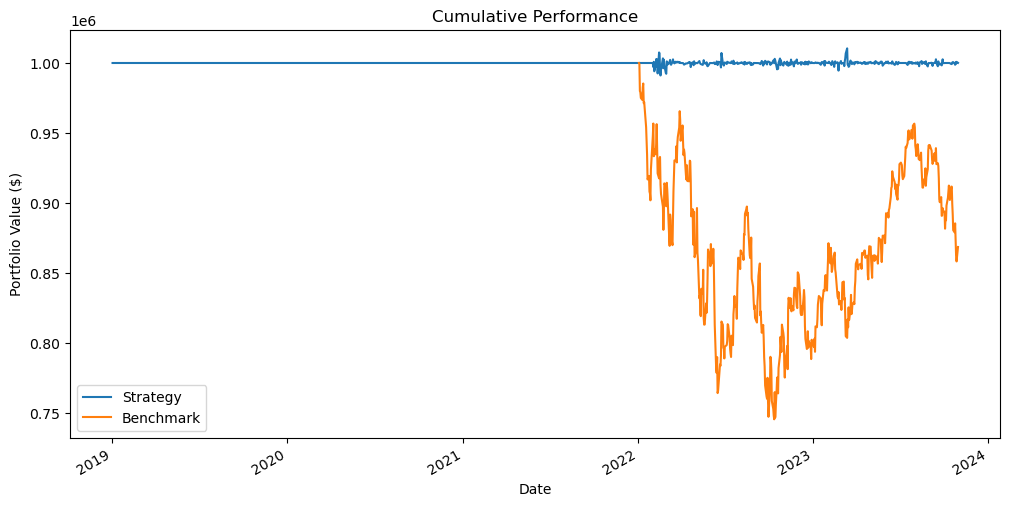

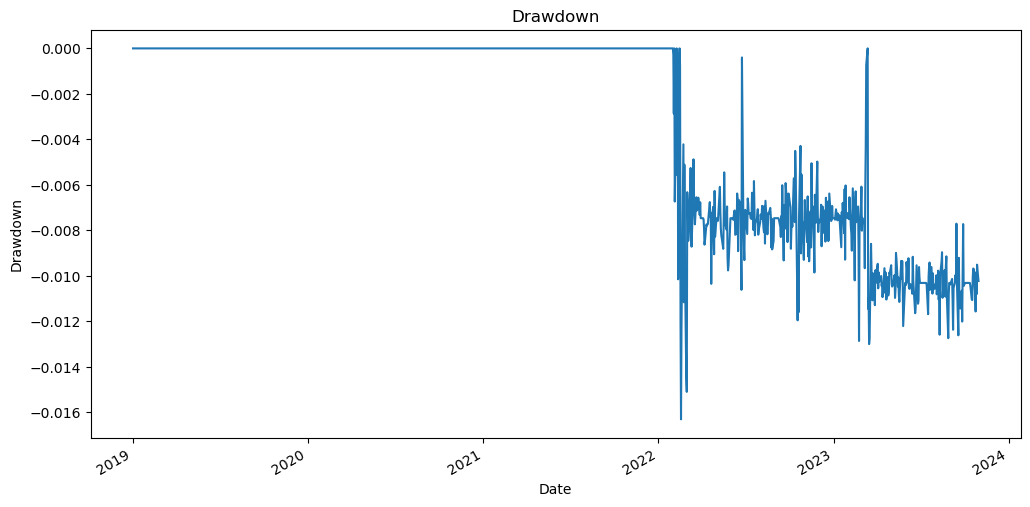

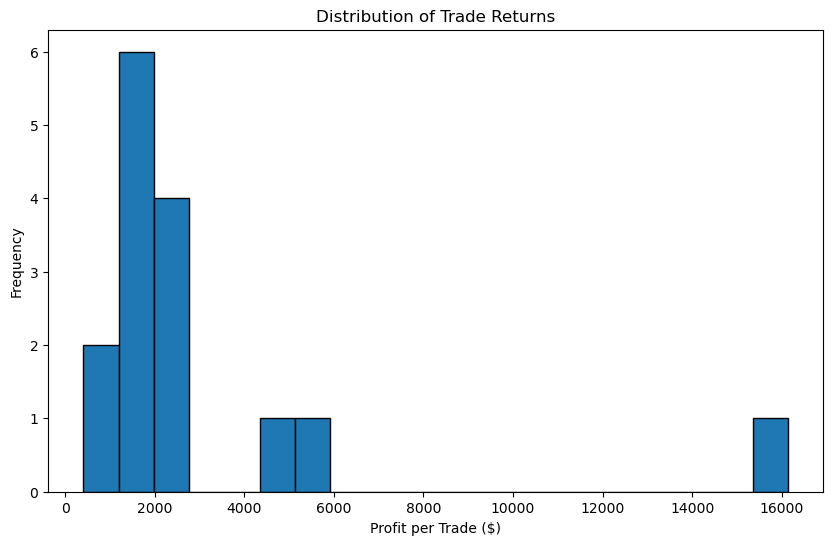

In [ ]:
# Visualize Performance

plt.figure(figsize=(12,6))
portfolio['total'].plot(label='Strategy')
benchmark_cumulative = (1 + benchmark_returns).cumprod() * initial_capital # S&P 500 as benchmark
benchmark_cumulative = benchmark_cumulative.reindex(portfolio.index).fillna(method='ffill')
benchmark_cumulative.plot(label='Benchmark')
plt.title('Cumulative Performance')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
drawdown.plot(title='Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.show()


plt.figure(figsize=(10,6))
plt.hist(transaction_profits, bins=20, edgecolor='k')
plt.title('Distribution of Trade Returns')
plt.xlabel('Profit per Trade ($)')
plt.ylabel('Frequency')
plt.show()


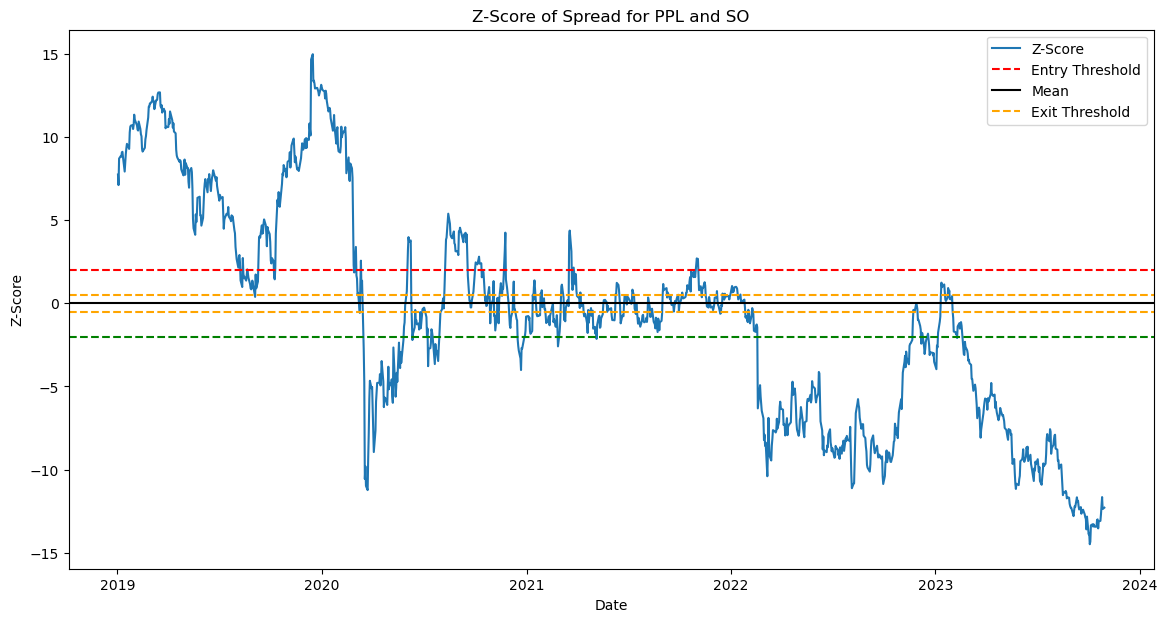

In [ ]:
# Z-Score Plot for a Pair
selected_pair = list(pair_data.keys())[0]  # first pair
stock1, stock2 = selected_pair
beta = pair_data[selected_pair]['beta']
mean = pair_data[selected_pair]['mean']
std = pair_data[selected_pair]['std']

y = price_data[stock1]
x = price_data[stock2]
spread = y - beta * x
zscore = (spread - mean) / std

plt.figure(figsize=(14,7))
plt.plot(zscore.index, zscore, label='Z-Score')
plt.axhline(2, color='red', linestyle='--', label='Entry Threshold')
plt.axhline(-2, color='green', linestyle='--')
plt.axhline(0, color='black', linestyle='-', label='Mean')
plt.axhline(0.5, color='orange', linestyle='--', label='Exit Threshold')
plt.axhline(-0.5, color='orange', linestyle='--')
plt.title(f'Z-Score of Spread for {stock1} and {stock2}')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.show()
